<font color = 'red'> Task 1: </font> There are 7 jurors in the courtroom. Each of them individually can correctly determine whether the defendant is guilty or not with 80% probability. How likely is the jury will make a correct verdict jointly if the decision is made by majority voting?

In [7]:
print(round((35*(0.8**4)*(.2**3)+21*(0.8**5)*(.2**2)+7*(0.8**6)*(.2**1)+1*(0.8**7)*1)*100, 2), '%')

96.67 %


<font color = 'red'> Answer(1): </font> 96.66%

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



Let us implement a function that will replace the NaN values by the median in each column of the table.


In [9]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table  



Reading the data:


In [10]:
data = pd.read_csv('../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


View data types of the features:

In [11]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object



Look at the distribution of classes in target:


Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

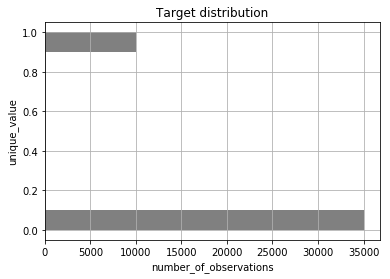

In [13]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='gray')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Select all the features and drop the target:

In [14]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

We apply a function that replaces all values of NaN by the median value of the corresponding column.

In [15]:
table = impute_nan_with_median(data)



Split the target and features - now we get a training sample.


In [16]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

# Bootstrap

<font color = 'red'> Task 2. </font> Make an interval estimate based on the bootstrap of the average income (MonthlyIncome) of customers who had overdue loan payments, and of those who paid in time, make 90% confidence interval. Find the difference between the lower limit of the derived interval for those who paid in time and the upper limit for those who are overdue. So, you are asked to build 90% intervals for the income of "good" customers [good_income_lower,good_income_upper] and for "bad" - [bad_income_lower,bad_income_upper] and find the difference good_income_lower−bad_income_upper.

In [54]:
table['bad_guys'] = ((table['NumberOfTime30-59DaysPastDueNotWorse'] >0)|\
      (table['NumberOfTime60-89DaysPastDueNotWorse'] >0)|\
      (table['NumberOfTimes90DaysLate'] >0)).astype('int')

In [33]:
z = table[table['SeriousDlqin2yrs']==1]['age'].values
z[2]

37

In [65]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
np.random.seed(17)
good_guys = table[table['bad_guys']==0]['MonthlyIncome'].values
bad_guys = table[table['bad_guys']==1]['MonthlyIncome'].values

bad = np.mean(gener(good_guys, 1000), axis=1)
good = np.mean(gener(bad_guys, 1000), axis=1)

print('interval`naia-naval`naia = ', stat_intervals(good, 0.1))
print('interval` = ', stat_intervals(bad, 0.1))
print(stat_intervals(good, 0.1)[0] - stat_intervals(bad, 0.1)[0] )
#good_income_lower−bad_income_upper.

interval`naia-naval`naia =  [5730.22859119 5991.54973516]
interval` =  [6251.00625193 6465.35205621]
-520.7776607351998


In [66]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
np.random.seed(17)
good_guys = table[table['SeriousDlqin2yrs']==0]['MonthlyIncome'].values
bad_guys = table[table['SeriousDlqin2yrs']==1]['MonthlyIncome'].values

bad = np.mean(gener(good_guys, 1000), axis=1)
good = np.mean(gener(bad_guys, 1000), axis=1)

print('interval`naia-naval`naia = ', stat_intervals(good, 0.1))
print('interval` = ', stat_intervals(bad, 0.1))
print(stat_intervals(good, 0.1)[0] - stat_intervals(bad, 0.1)[0] )
#good_income_lower−bad_income_upper.

interval`naia-naval`naia =  [5471.64826451 5643.93562737]
interval` =  [6295.93237577 6505.35467934]
-824.2841112619117


In [58]:
#table.head(20)

In [ ]:
['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']